In [102]:
THRESHOLD = 4 * 1e-1

In [1]:
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [2]:
df = pd.read_csv("/home/shirobokov/data/diff_gen_data/physics_data/xz_magnet_opt.csv", index_col=0)

In [3]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

exp = comet_api.get("shir994/physics-2d/76bdfb7db00441e0a1a52b91a3393fed")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [4]:
hyper_params['NOISE_DIM'] = int(hyper_params['NOISE_DIM'])
hyper_params['param_dim'] = int(hyper_params['param_dim'])
hyper_params['x_dim'] = int(hyper_params['x_dim'])

In [6]:
gan_file_link = [exp_a['link'] for exp_a in exp.asset_list if exp_a['fileName'] == "gan.py"][0]

In [ ]:
!wget -O -->"gan_file_link"

In [11]:
from gan import Generator
generator = Generator(hyper_params['NOISE_DIM'], 3, hidden_dim=100,
          input_param=hyper_params['param_dim'] + hyper_params['x_dim']).to(device)

import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "physics_gan.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))
generator.load_state_dict(state_dict['gen_state_dict'])

In [12]:
def sample_noise(N, NOISE_DIM):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

def genearte_plot_data(n_samples, magn_len, magn_x):
        theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
        phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
        p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

        pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
        pids[pids == 1] = 13.
        pids[pids == 0] = -13.

        noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
        distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len, magn_x], dim=1).to(device)).detach().cpu().numpy()     
        return distr

In [13]:
import random

In [17]:
mask = np.logical_and(df.magn_len == sampled_len, df.magn_x == sampled_x)

In [26]:
# df.hit_x = (df.hit_x - df.hit_x.mean()) / df.hit_x.std()
# df.hit_y = (df.hit_y - df.hit_y.mean()) / df.hit_y.std()

In [ ]:
magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
magn_x = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 10).repeat([n_samples, 1])
distr = genearte_plot_data(n_samples, magn_len, magn_x)
#distr = distr[distr[:, 2] > 5 * 1e-1]
#distr = distr[np.logical_and(np.abs(distr[:, 0]) >= 0.1, np.abs(distr[:, 1]) >= 0.1)]
#print((np.abs(distr[:,0]) < 0.05).sum())
plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10)
plt.grid()
plt.colorbar()

In [52]:
def generate_data(n_samples, magn_len, magn_x):
    magn_len = torch.Tensor([magn_len]).repeat([n_samples, 1])
    magn_x = torch.Tensor([magn_x]).repeat([n_samples, 1])
    return genearte_plot_data(n_samples, magn_len, magn_x)

11 2


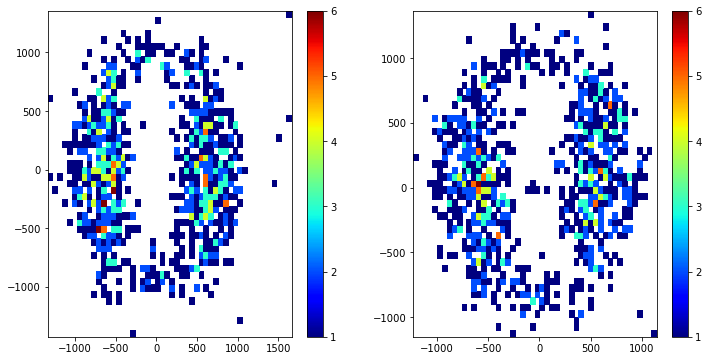

In [82]:
sampled_len = random.randint(1, 14)
sampled_x = random.randint(1, 9)
print(sampled_len, sampled_x)


mask = np.logical_and(df.magn_len == sampled_len, df.magn_x == sampled_x)
mask = np.logical_and(df.hit_E > 0, mask)

plt.subplot(1,2,1)
plt.hist2d(df[mask].hit_x, df[mask].hit_y,
           bins=50, cmap=my_cmap, cmin=1e-10);
plt.colorbar()
plt.subplot(1,2,2)
n_samples = 2000
gen_data = generate_data(n_samples, sampled_len, sampled_x)
gen_data = gen_data[gen_data[:, 2] > 5 * 1e-1]
plt.hist2d(gen_data[:, 0] * df.hit_x.std() + df.hit_x.mean(), gen_data[:, 1] * df.hit_y.std() + df.hit_y.mean(),
           bins=50, cmap=my_cmap, cmin=1e-10);
plt.colorbar()

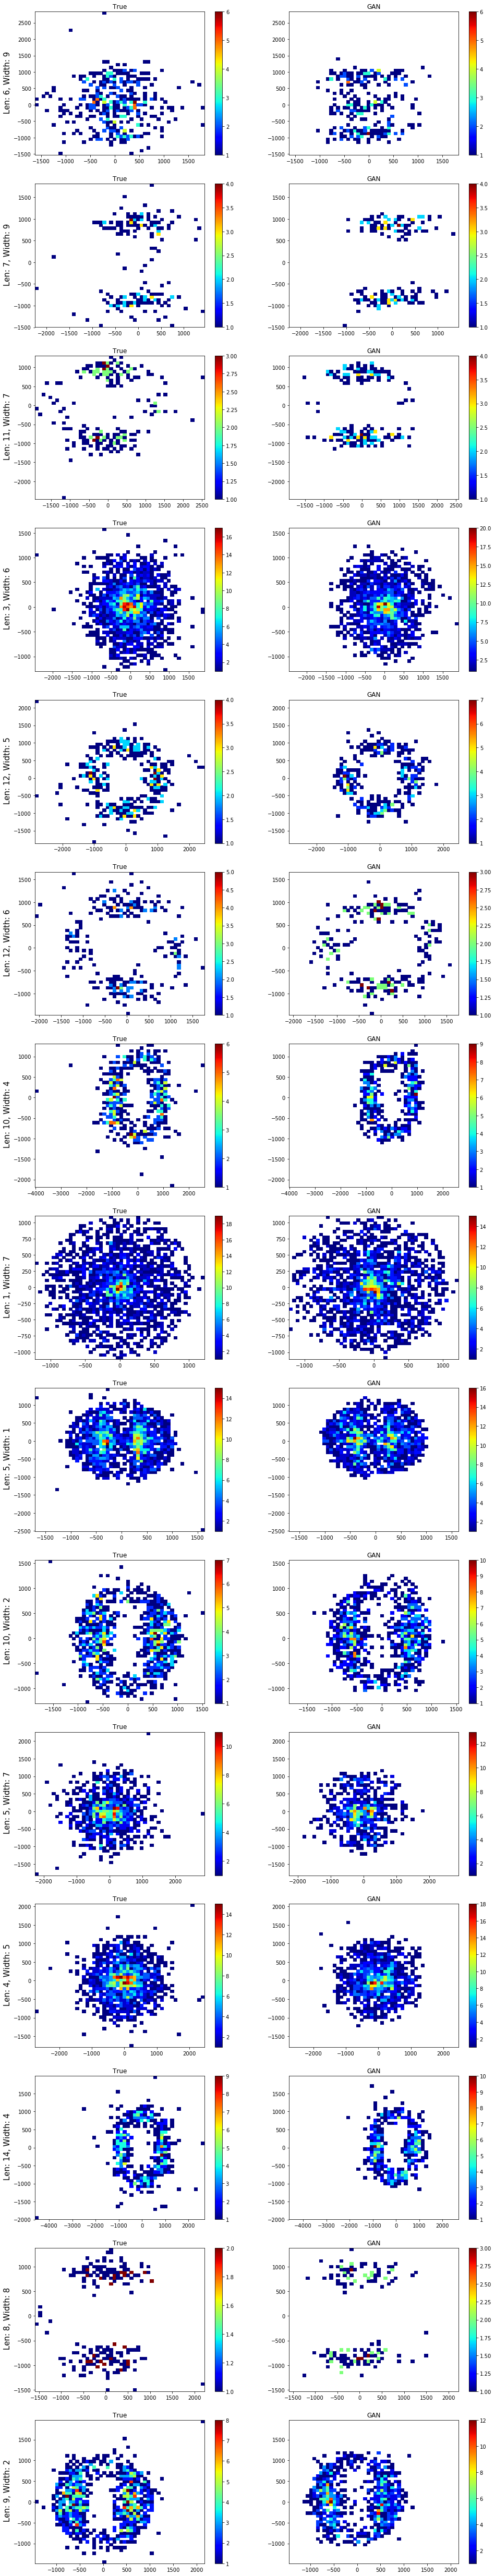

In [100]:
f = plt.figure(figsize=(16,90))

sampl_to_lot = 15
n_samples = 2000
for index in range(sampl_to_lot):
    sampled_len = random.randint(1, 14)
    sampled_x = random.randint(1, 9)
    mask = np.logical_and(df.magn_len == sampled_len, df.magn_x == sampled_x)
    mask = np.logical_and(df.hit_E > 0, mask)
    
    plt.subplot(sampl_to_lot, 2, 2*index + 1)
    plt.hist2d(df[mask].hit_x, df[mask].hit_y,
               bins=50, cmap=my_cmap, cmin=1e-10);
    plt.colorbar()    
    plt.title("True")
    plt.ylabel(f" Len: {sampled_len}, Width: {sampled_x}", fontsize=15)
    
    
    plot_ranges = ((df[mask].hit_x.min(), df[mask].hit_x.max()), (df[mask].hit_y.min(), df[mask].hit_y.max()))
    plt.subplot(sampl_to_lot, 2, 2*index + 2)
    gen_data = generate_data(n_samples, sampled_len, sampled_x)
    gen_data = gen_data[gen_data[:, 2] > 5 * 1e-1]
    plt.hist2d(gen_data[:, 0] * df.hit_x.std() + df.hit_x.mean(), gen_data[:, 1] * df.hit_y.std() + df.hit_y.mean(),
               bins=50, cmap=my_cmap, cmin=1e-10, range=plot_ranges);
    plt.colorbar()
    plt.title("GAN")
plt.savefig("2d_plots/hits_comparison.pdf")    

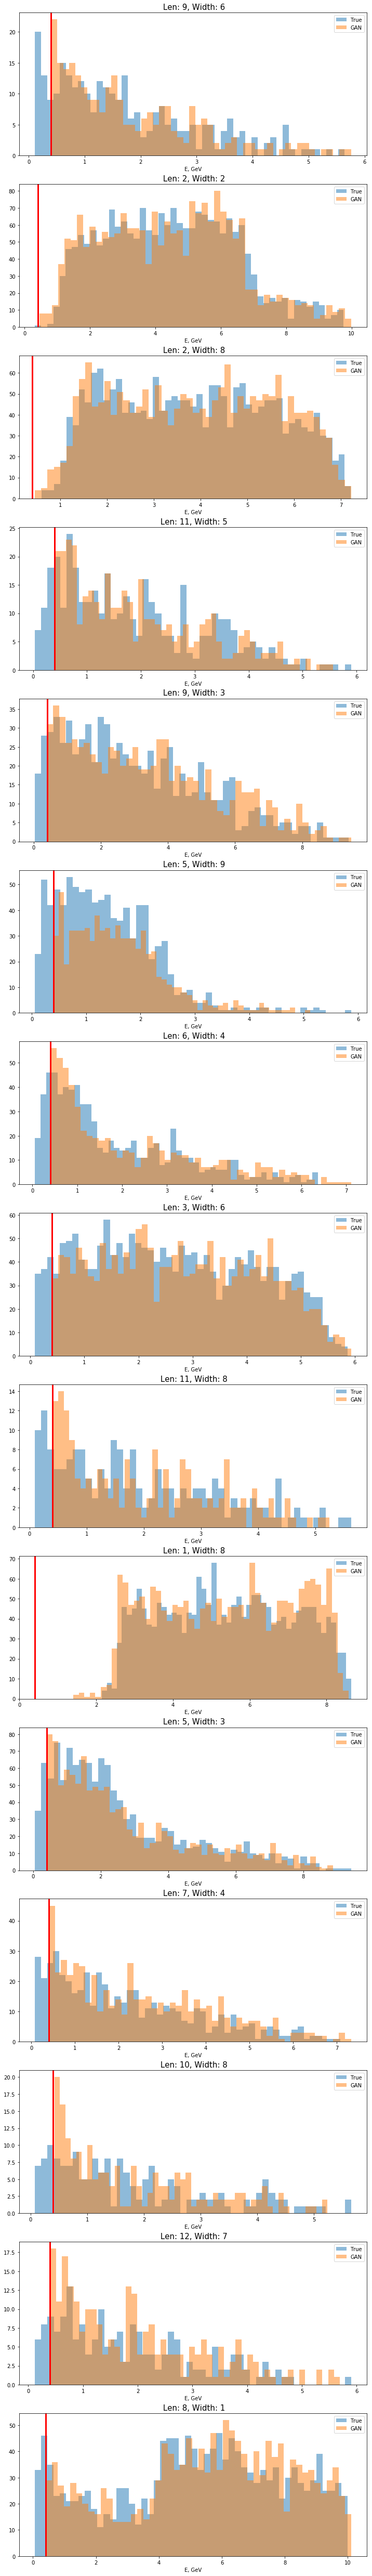

In [161]:
f = plt.figure(figsize=(12,90))

sampl_to_lot = 15
n_samples = 2000
for index in range(sampl_to_lot):
    plt.subplot(sampl_to_lot, 1, index+1)
    sampled_len = random.randint(1, 14)
    sampled_x = random.randint(1, 9)
    mask = np.logical_and(df.magn_len == sampled_len, df.magn_x == sampled_x)
    mask = np.logical_and(df.hit_E > 0, mask)    
    plt.hist(df[mask].hit_E, bins=50, label="True", alpha=0.5)
    
    gen_data = generate_data(n_samples, sampled_len, sampled_x)
    gen_data = gen_data[gen_data[:, 2] > THRESHOLD]
    plt.hist(gen_data[:,2], bins=50, label="GAN", alpha=0.5)

    plt.title(f" Len: {sampled_len}, Width: {sampled_x}", fontsize=15)
    plt.legend()
    plt.xlabel("E, GeV")
    plt.axvline(x=THRESHOLD, c='r', linewidth=3)
plt.savefig("2d_plots/energy_distr_comparison_passed.pdf")     

In [168]:
THRESHOLD = 4 * 1e-1

In [169]:
n_samples = 5000

diff = []
config = []
for sampled_len in range(1,15):
    for sampled_x in range(1,10):
        mask = np.logical_and(df.magn_len == sampled_len, df.magn_x == sampled_x)
        total_num_of_particles = mask.sum()
        mask = np.logical_and(df.hit_E > 0, mask)
        true_frac_stopped = 1. - mask.sum() / total_num_of_particles
        
        gen_data = generate_data(n_samples, sampled_len, sampled_x)
        gen_frac_stopped = 1. - gen_data[gen_data[:, 2] > THRESHOLD].shape[0] / n_samples
        diff.append(true_frac_stopped - gen_frac_stopped)
        config.append([sampled_len, sampled_x])

Text(0.5, 0, 'True_stop_frac - gen_stop_frac')

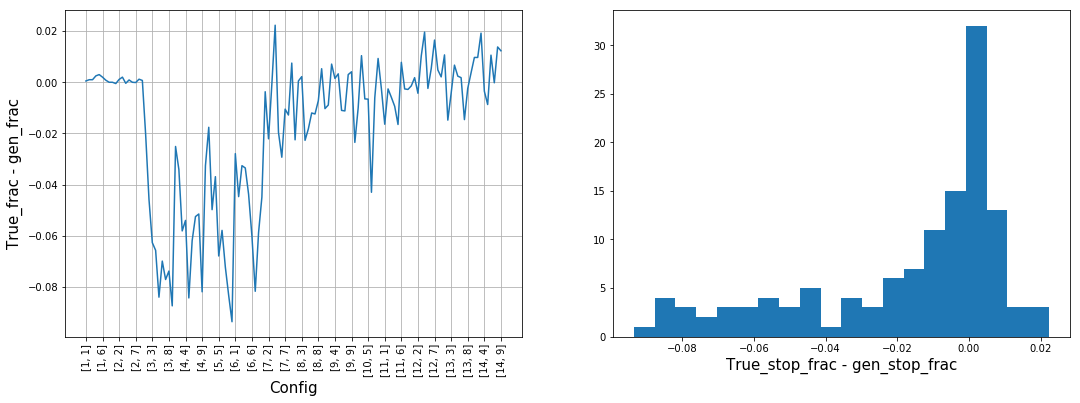

In [170]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(diff)
plt.xticks(range(len(config))[::5], labels=config[::5], rotation=90)
plt.xlabel("Config", fontsize=15)
plt.ylabel("True_frac - gen_frac", fontsize=15)
plt.grid()
plt.subplot(1,2,2)
plt.hist(diff, bins=20);
plt.xlabel("True_stop_frac - gen_stop_frac", fontsize=15)
#plt.savefig("2d_plots/stopped_frac_diff.pdf")

In [134]:
bad_configs = np.array(diff).argsort()

In [136]:
np.array(config)[bad_configs][:10]

array([[5, 9],
       [6, 7],
       [3, 9],
       [3, 6],
       [3, 5],
       [5, 8],
       [4, 6],
       [3, 8],
       [3, 4],
       [5, 7]])